# 去标识

请点击[这里](https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_with_pii.csv)下载数据集，并将下载得到的数据集放置在与本章Jupyter笔记本相同的目录下。

此数据集是根据人口普查数据修改得到的。数据集中的个人标识信息（Personal Identifiable Information，PII）经过了虚构处理。

In [3]:
import pandas as pd
import numpy as np
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')

In [4]:
adult = pd.read_csv("adult_with_pii.csv")
adult.head()

Name        DOB          SSN    Zip  Age         Workclass  \
0  Karrie Trusslove   9/7/1967  732-14-6110  64152   39         State-gov   
1  Brandise Tripony   6/7/1988  150-19-2766  61523   50  Self-emp-not-inc   
2     Brenn McNeely   8/6/1991  725-59-9860  95668   38           Private   
3       Dorry Poter   4/6/2009  659-57-4974  25503   53           Private   
4       Dick Honnan  9/16/1951  220-93-3811  75387   28           Private   

   fnlwgt  Education  Education-Num      Marital Status         Occupation  \
0   77516  Bachelors             13       Never-married       Adm-clerical   
1   83311  Bachelors             13  Married-civ-spouse    Exec-managerial   
2  215646    HS-grad              9            Divorced  Handlers-cleaners   
3  234721       11th              7  Married-civ-spouse  Handlers-cleaners   
4  338409  Bachelors             13  Married-civ-spouse     Prof-specialty   

    Relationship   Race     Sex  Capital Gain  Capital Loss  Hours per week  \
0  Not-in-family  White    Male          2174             0              40   
1        Husband  White    Male             0             0              13   
2  Not-in-family  White    Male             0             0              40   
3        Husband  Black    Male             0             0              40   
4           Wife  Black  Female             0             0              40   

         Country Target  
0  United-States  <=50K  
1  United-States  <=50K  
2  United-States  <=50K  
3  United-States  <=50K  
4           Cuba  <=50K

# 去标识

*去标识*（De-identification）是指从数据集中删除*标识信息*的过程。有的地方会把*去标识*这一术语与*匿名*（Anonymization）和*假名*（Pseudonymization）这两个术语看作同义词，表达相同的概念。

```{admonition} 学习目标
阅读本章后，您将能够：
- 定义并理解下述概念：
  - 去标识
  - 重标识
  - 标识信息 / 个人标识信息
  - 关联攻击
  - 聚合与聚合统计
  - 差分攻击
- 实施一次关联攻击
- 实施一次差分攻击
- 理解去标识技术的局限性
- 理解聚合统计的局限性
```

我们尚不能严谨地定义什么是标识信息。我们通常将标识信息理解为：在日常生活中可以唯一标识我们自己的信息。从这个理解角度看，姓名、地址、电话号码、电子邮箱等都属于标识信息。我们稍后将会了解到，*不可能*为标识信息给出严谨的定义，因为*所有*信息都可以用来标识个体。一般来说，*个人标识信息*（Personally Identifiable Information，PII）和标识信息这两个术语是同义词，表达相同的概念。

我们如何才能对信息去标识呢？很简单，我们直接移除包含标识信息的列就好了！

In [12]:
adult_data = adult.copy().drop(columns=['Name', 'SSN'])
adult_pii = adult[['Name', 'SSN', 'DOB', 'Zip']]
adult_data.head(1)

DOB    Zip  Age  Workclass  fnlwgt  Education  Education-Num  \
0  9/7/1967  64152   39  State-gov   77516  Bachelors             13   

  Martial Status    Occupation   Relationship   Race   Sex  Capital Gain  \
0  Never-married  Adm-clerical  Not-in-family  White  Male          2174   

   Capital Loss  Hours per week        Country Target  
0             0              40  United-States  <=50K

我们将数据中一部分个体的标识信息保留了下来。我们随后将把这些保留的标识信息作为*辅助数据*（Auxiliary Data）来实施一次*重标识*（Re-identification）攻击。

## 关联攻击

假设我们想从刚刚得到的去标识数据中获取某个朋友的收入信息。去标识数据中的姓名一列已经被移除了，但我们碰巧知道能帮助我们标识出这位朋友的一些辅助信息。我们的这位朋友叫凯莉·特鲁斯洛夫（Karrie Trusslove），我们知道凯莉的出生日期和邮政编码。

我们尝试攻击的数据集与我们知道的一些辅助信息之间包含一些重叠列，我们将应用这些重叠列来实施一次简单的*关联攻击*（Linkage Attack）。在本例中，两个数据集都包含出生日期和邮政编码列。我们在尝试攻击的数据集中查找出能与凯莉的出生日期和邮政编码匹配上的行。数据库领域将此类匹配操作称为*关联*（JOIN）两个数据表。我们可以使用Pandas的`merge`函数实现此操作。如果我们只能检索到唯一一行数据，我们就从尝试攻击的数据集中找到了凯莉所属的行。

In [17]:
karries_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove']
pd.merge(karries_row, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])

Name          SSN       DOB    Zip  Age  Workclass  fnlwgt  \
0  Karrie Trusslove  732-14-6110  9/7/1967  64152   39  State-gov   77516   

   Education  Education-Num Martial Status    Occupation   Relationship  \
0  Bachelors             13  Never-married  Adm-clerical  Not-in-family   

    Race   Sex  Capital Gain  Capital Loss  Hours per week        Country  \
0  White  Male          2174             0              40  United-States   

  Target  
0  <=50K

我们确实只找到了一行匹配上的数据。通过使用辅助数据，我们在去标识数据集中重标识出了一个个体。我们可以根据重标识攻击结果进一步推断出凯莉的收入小于5万美元。

### 重标识出凯莉有多难？

这是一个虚构的攻击场景，但在实际场景中实施关联攻击的难度也是出乎意料的低。有多低呢？事实证明，在绝大多数情况下，只需要一个数据点作为辅助信息就足以重标识出一行数据！

In [18]:
pd.merge(karries_row, adult_data, left_on=['Zip'], right_on=['Zip'])

Name          SSN     DOB_x    Zip     DOB_y  Age  Workclass  \
0  Karrie Trusslove  732-14-6110  9/7/1967  64152  9/7/1967   39  State-gov   

   fnlwgt  Education  Education-Num Martial Status    Occupation  \
0   77516  Bachelors             13  Never-married  Adm-clerical   

    Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0  Not-in-family  White  Male          2174             0              40   

         Country Target  
0  United-States  <=50K

邮政编码*本身*就足以让我们重标识出凯莉了。那出生日期呢？

In [19]:
pd.merge(karries_row, adult_data, left_on=['DOB'], right_on=['DOB'])

Name          SSN       DOB  Zip_x  Zip_y  Age  \
0  Karrie Trusslove  732-14-6110  9/7/1967  64152  64152   39   
1  Karrie Trusslove  732-14-6110  9/7/1967  64152  67306   64   
2  Karrie Trusslove  732-14-6110  9/7/1967  64152  62254   46   

          Workclass  fnlwgt  Education  Education-Num      Martial Status  \
0         State-gov   77516  Bachelors             13       Never-married   
1           Private  171373       11th              7             Widowed   
2  Self-emp-not-inc  119944    Masters             14  Married-civ-spouse   

        Occupation   Relationship   Race     Sex  Capital Gain  Capital Loss  \
0     Adm-clerical  Not-in-family  White    Male          2174             0   
1  Farming-fishing      Unmarried  White  Female             0             0   
2  Exec-managerial        Husband  White    Male             0             0   

   Hours per week        Country Target  
0              40  United-States  <=50K  
1              40  United-States  <=50K  
2              50  United-States   >50K

这一次返回了三行数据。我们不知道哪一行才是凯莉的数据。即便如此，我们仍然得到了很多信息！

- 我们知道凯莉收入低于5万美元的概率是2/3。
- 我们可以观察各行之前的差异，以确定哪些额外的辅助信息可以*帮助*我们进一步区分各行数据所属的个体。在本例中，性别、职业、婚姻状况都可以帮助我们进一步重标识出凯莉。

### 凯莉很特别吗？

在数据集中重标识出其他某个个体的难度有多大？重标识出凯莉这一特定的个体相对更难还是相对更简单呢？衡量此类攻击有效性的一个好方法是查看特定数据是否有较好的"筛选效果"：特定数据能否帮助我们更好地缩小目标个体所属行的范围。举个例子，数据集中拥有相同出生日期的人数多吗？

在执行攻击前，我们可以先评估一下出生日期这一辅助数据会给我们带来多大的帮助。为此，我们可以查看数据集中包含"唯一"出生日期的个体数量。下面的直方图显示，*绝大多数*出生日期在数据集中仅出现了1次、2次或3次，有8个个体的出生日期信息是缺失的。这意味着出生日期的"筛选效果"相当不错。出生日期可以有效缩小个体所属行的范围。

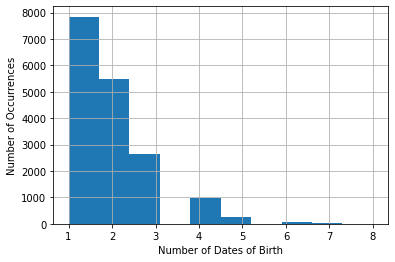

In [26]:
adult_pii['DOB'].value_counts() .hist()
plt.xlabel('生日数量')
plt.ylabel('出现次数');

我们可以利用相同的方法衡量邮政编码的筛选效果。这次的结果变得更夸张了：邮政编码在此数据集中的筛选效果*非常*好。几乎所有的邮政编码在此数据集中都只出现了一次。

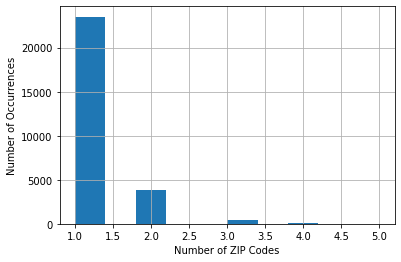

In [27]:
adult_pii['Zip'].value_counts().hist()
plt.xlabel('邮政编码数量')
plt.ylabel('出现次数');

### 我们可以重标识出多少个个体？

我们可以在此数据集中重标识出多少个个体呢？我们可以使用我们的辅助信息来找到这个问题的答案！首先，让我们看看只有出生日期会发生什么。我们想知道辅助数据中的每个出生日期能帮助我们重标识出数据集中多少*可能的身份*。下面的直方图显示了每个可能身份的数量。在大约32000行数据中，我们可以唯一标识出近7000行数据，并将约10000行数据缩小至两个可能的身份。

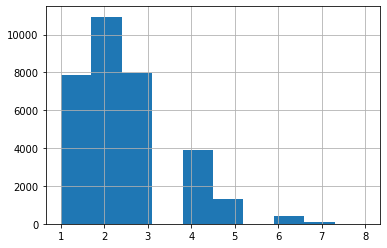

In [33]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB'], right_on=['DOB'])
attack['Name'].value_counts().hist();

因此，*仅*通过出生日期来重标识大多数个体是不太可行的。如果我们收集更多的信息，进一步缩小范围呢？如果我们同时使用出生日期和邮政编码作为辅助数据，则重标识效果会变得更好。实际上，我们基本能够对数据集中的全部数据成功实施重标识攻击。

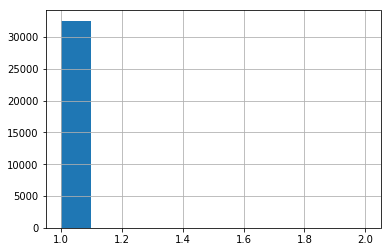

In [17]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])
attack['Name'].value_counts().hist();

当我们同时使用两部分信息实施重标识攻击时，我们可以重标识出**所有的个体**。这是一个非常令人惊讶的实验结果，因为我们通常认为很多人的出生日期都相同，而很多人居住地所属的邮政编码也会相同。事实证明，*组合*使用这些信息会得到**非常好**的筛选效果。拉坦娅·斯威尼（Latanya Sweeney）的研究结果表明{cite}`identifiability`，组合使用出生日期、性别、邮政编码，可以唯一重标识出87%的美国公民。

我们来验证一下是否真的能重标识出*所有的个体*。我们打印出每个身份可能关联到的数据记录数量。

In [18]:
attack['Name'].value_counts().head()

Barnabe Haime       2
Antonin Chittem     2
Penelope Fauning    1
Sylvia Kenan        1
Sadella Gutowski    1
Name: Name, dtype: int64

看来有两个个体抵御了重标识攻击！换句话说，在这个数据集中，只有**两个个体**同时拥有相同的邮政编码和出生日期。

## 聚合

另一种防止隐私信息泄露的方法是只发布*聚合*（Aggregate）数据。

In [21]:
adult['Age'].mean()

38.58164675532078

### 小群组问题

在很多情况下，我们需要将数据分组，并分别给出各个分组的聚合统计结果。举例来说，我们可能想知道取得不同学位个体的平均年龄。

In [34]:
adult[['Education-Num', 'Age']].groupby('Education-Num').mean().head(3)

Age
Education-Num           
1              42.764706
2              46.142857
3              42.885886

一般认为，对数据进行聚合处理可以提升数据的隐私保护效果，因为很难识别出特定个体对聚合统计结果所带来的影响。但如果某个分组*只包含一个个体*呢？在这种情况下，举个统计结果将*准确*泄露此个体的年龄，无法提供任何隐私保护！在我们的数据集中，大多数个体的邮政编码的唯一的。因此，如果我们计算不同邮政编码所属个体的平均年龄，则大多数"平均值"将直接泄露单一个体的年龄。

In [35]:
adult[['Zip', 'Age']].groupby('Zip').mean().head()

Age
Zip      
4    55.0
12   24.0
16   59.0
17   42.0
18   24.0

例如，美国人口普查局以[*区为粒度*](https://www.census.gov/newsroom/blogs/random-samplings/2011/07/what-are-census-blocks.html)发布聚合统计数据。有些人口普查区的人口众多，但有些人口普查区的人口为0！事实证明，聚合统计结果无法隐藏小分组的个体信息的情况相当普遍。

分组要达到多大，聚合统计结果才能隐藏个体信息呢？很难回答这个问题，因为只有当知道数据本身和具体的攻击方法时，才能回答这个问题。因此，很难确信聚合统计结果真的能达到隐私保护的目的。然而，我们接下来将会看到，即使分组足够大，也可以实施相应的攻击，从聚合结果中获得个体信息。

### 差分攻击

当对相同的数据发布多个聚合统计结果时，隐私泄露问题会变得棘手。例如，考虑对数据集中某个大分组执行两次求和问询（第一个是对整个数据集进行问询，第二个是对除一条记录外的所有记录进行问询）：

In [36]:
adult['Age'].sum()

1256257

In [37]:
adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

1256218

如果我们得到了这两个问询的回答，我们可以简单地对结果求减法，从而准确获得凯莉的年龄！即使在*非常大的分组下*发布聚合统计结果，我们仍然可以实施这一攻击。

In [38]:
 adult['Age'].sum() - adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

39

下述问题将在本书中反复出现。

- 发布可用性很高的*数据*会提高隐私保护的难度。
- 很难区分*恶意*和*非恶意*问询。

## 总结

- *关联攻击*指的是组合使用*辅助数据*和*去标识数据*来*重标识*个体。
- 实施关联攻击最简单的方法是：将数据集中的两个数据表*关联*起来。
- 即使实施简单的关联攻击，攻击效果也非常显著：
  - 只需要一个辅助数据点，就足以把攻击范围缩小到几条记录
  - 缩小后的记录可以进一步显示出哪些额外的辅助数据会有助于进一步实施攻击
  - 对于一个特定的数据集，两个数据点一般足以重标识出绝大多数个体
  - 三个数据点（性别、邮政编码、出生日期）可以唯一重标识出87%的美国公民